In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
protein_name = '6THL'
cluster_id = 1

dfs = []
for i in range(5):
    fpath = f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/prediction/HDX_pred_GN_{protein_name}_cluster{cluster_id}_v{i}.csv'
    #fpath = f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/prediction/HDX_pred_GN_cluster2_hop1_v{cluster_id}.csv'
    df = pd.read_csv(fpath)
    print(df.shape)
    dfs.append(df)
merged_df = pd.concat(dfs, axis=0)
average_df = merged_df.groupby(['Batch', 'Chain', 'Range', 'Y_True'])['Y_Pred'].mean().reset_index()

HDX_fpath = '/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/HDX_files/PXD023434_revised.xlsx'

print(average_df.head())
print(average_df.shape)

(12048, 5)
(12048, 5)
(12048, 5)
(12048, 5)
(12048, 5)
  Batch  Chain    Range    Y_True    Y_Pred
0  6THL      0  126-137  0.148537  0.459394
1  6THL      0  129-137  0.290016  0.475354
2  6THL      0  148-158  0.168191  0.345360
3  6THL      0  175-182  0.422244  0.849049
4  6THL      0  188-195  0.089625  0.405029
(12048, 5)


rtt Rtt (22, 11)
rtt Rtt_Bcd (22, 11)
22
bcdFL Bcd (49, 11)
bcdFL Bcd_Rtt (49, 11)
49


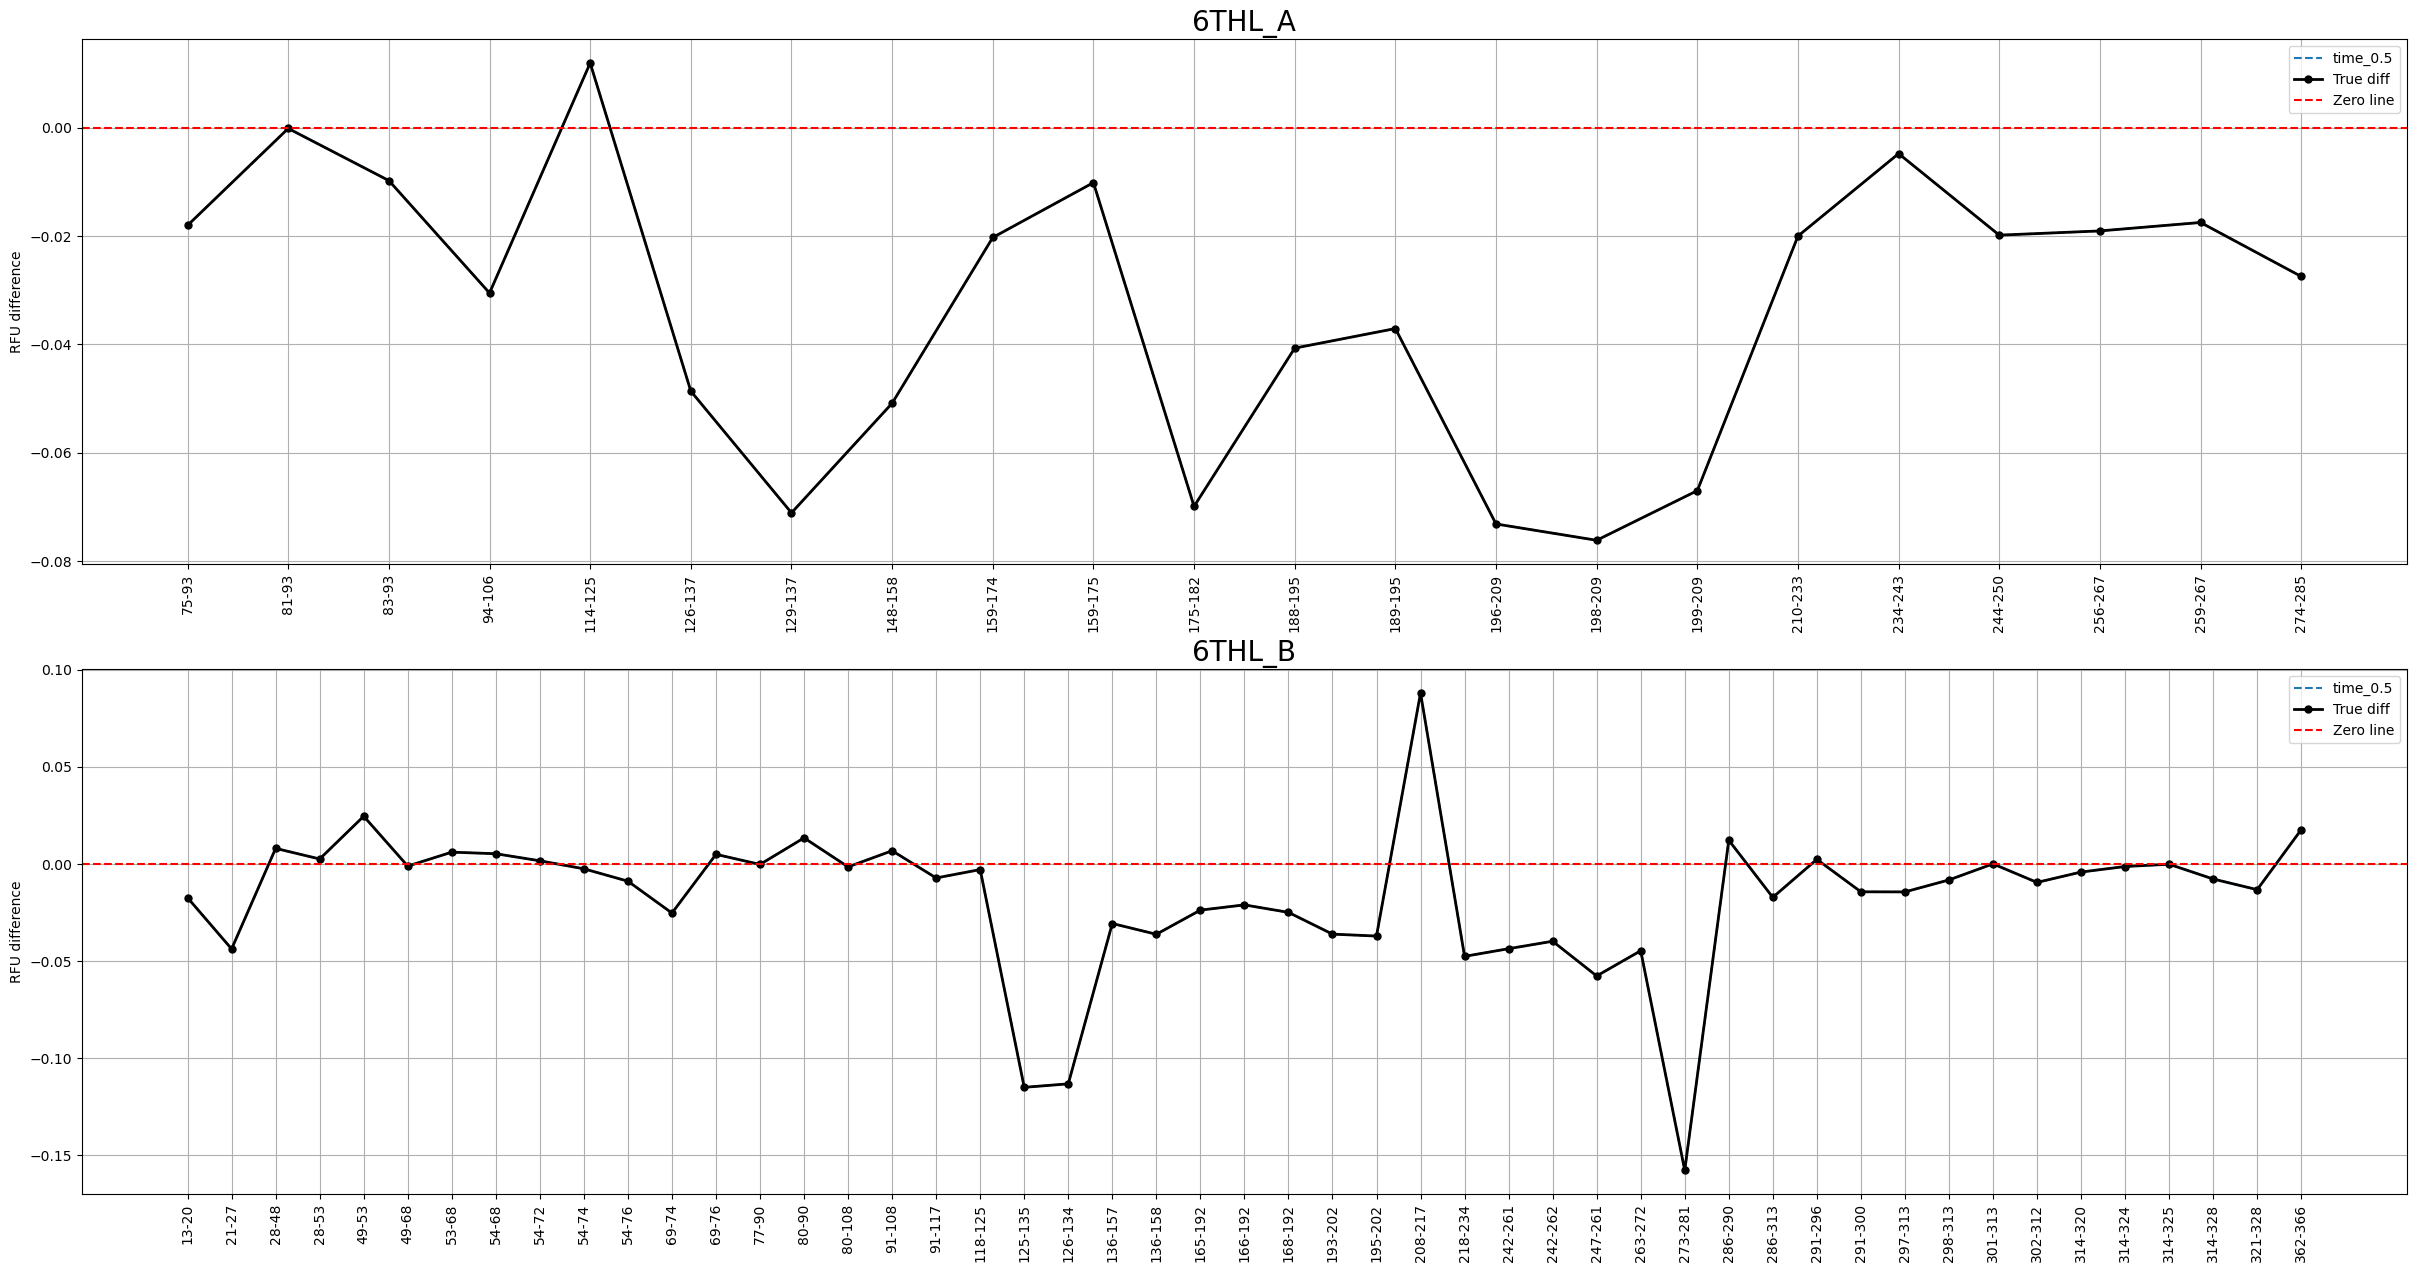

In [28]:
# get average uptake from source HDX file
# return true_diff dictionary =  [Range]: diff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_true_diff(HDX_fpath, apo_states, complex_states):
    def get_weighted_uptake(HDX_df, protein, state, correction):
        temp_HDX_df = HDX_df[(HDX_df['state']==state) & (HDX_df['protein']==protein)]
        temp_HDX_df = temp_HDX_df[(temp_HDX_df['log_t']<2) & (temp_HDX_df['log_t']>=1.35 )]
        #temp_HDX_df = temp_HDX_df[(temp_HDX_df['log_t']==4)]

        print(protein, state, temp_HDX_df.shape)
        temp_HDX_df = temp_HDX_df.sort_values(by=['start', 'end'], ascending=[True, True])

        exposures = temp_HDX_df['exposure'].unique()
        unweighted_RFU = {time:{} for time in exposures}
        for time in exposures:
            for index, row in temp_HDX_df[temp_HDX_df['exposure']==time].iterrows():
                unweighted_RFU[time][f'{row["start"]+correction}-{row["end"]+correction}'] = row['RFU']

        grouped = temp_HDX_df.groupby(['start', 'end'])
        weighted_uptake = grouped['RFU'].mean().to_numpy()/100
        unique_pairs = grouped.groups.keys()
        x_label = [f'{start+correction}-{end+correction}' for start, end in unique_pairs]

        return weighted_uptake, x_label, unweighted_RFU
    
    HDX_df = pd.read_excel(HDX_fpath)
    true_apo, true_complex = {}, {}
    apo_uptake, complex_uptake = [], []
    apo_mtx, complex_mtx = {}, {}

    for protein, state, correction in apo_states:
        uptake, label, U_apo_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
        #apo_uptake.append(uptake)
        for l, u in zip(label, uptake):
            true_apo[l] = u
        apo_mtx.update(U_apo_mtx)

    for protein, state, correction in complex_states:
        uptake, label, U_complex_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
        #complex_uptake.append(uptake)
        for l, u in zip(label, uptake):
            true_complex[l] = u
        complex_mtx.update(U_complex_mtx)

    true_diff = {}
    diff_mtx = {}
    for key in true_apo.keys():
        if key in true_complex:
            true_diff[key] = true_complex[key] - true_apo[key]
            diff_mtx[key] = {t: complex_mtx[t][key] - apo_mtx[t][key] for t in apo_mtx if key in apo_mtx[t] and key in complex_mtx[t]}
    
    print(len(true_diff.keys()))
    return true_diff, diff_mtx

# Delta true diff 
apo_states = [('rtt', 'Rtt', 0)]
complex_states = [('rtt', 'Rtt_Bcd', 0)]
true_diff, diff_RFU_mtx = get_true_diff(HDX_fpath, apo_states, complex_states)

plt.figure(figsize=(30, 15))
plt.tight_layout()
plt.subplot(2, 1, 1) # 2 row, 1 columns, 1st subplot
plt.title(f'6THL_A', fontsize=20)

x_labels = list(true_diff.keys())
x_positions = np.arange(len(x_labels))  # numerical positions for x-axis
plt.xticks(x_positions, x_labels, rotation=90)  # apply labels with rotation for clarity
all_times = set()
for diffs in diff_RFU_mtx.values():
    all_times.update(diffs.keys())
sorted_times = sorted(all_times, key=lambda x: float(x))
# Plotting each exposure time from diff_RFU_mtx
for time in sorted_times:
    time_values = [diff_RFU_mtx[label].get(time, 0) / 100 for label in x_labels]
    plt.plot(x_positions, time_values, label=f'time_{time}', linestyle='--', alpha=1)
plt.plot(x_positions, list(true_diff.values()), label='True diff', color='k', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.ylabel('RFU difference')
plt.axhline(y=0, color='r', linestyle='--', label='Zero line')
plt.grid(True)
plt.legend()

apo_states = [('bcdFL', 'Bcd', 0)]
complex_states = [('bcdFL', 'Bcd_Rtt', 0)]
true_diff, diff_RFU_mtx = get_true_diff(HDX_fpath, apo_states, complex_states)
plt.subplot(2, 1, 2) # 2 row, 1 columns, 1st subplot
plt.title(f'6THL_B', fontsize=20)

x_labels = list(true_diff.keys())
x_positions = np.arange(len(x_labels))  # numerical positions for x-axis
plt.xticks(x_positions, x_labels, rotation=90)  # apply labels with rotation for clarity
all_times = set()
for diffs in diff_RFU_mtx.values():
    all_times.update(diffs.keys())
sorted_times = sorted(all_times, key=lambda x: float(x))
# Plotting each exposure time from diff_RFU_mtx
for time in sorted_times:
    time_values = [diff_RFU_mtx[label].get(time, 0) / 100 for label in x_labels]
    plt.plot(x_positions, time_values, label=f'time_{time}', linestyle='--', alpha=1)
plt.plot(x_positions, list(true_diff.values()), label='True diff', color='k', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.ylabel('RFU difference')
plt.axhline(y=0, color='r', linestyle='--', label='Zero line')
plt.grid(True)
plt.legend()
plt.show()
#plt.savefig(f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/diff_HDX_{protein_name}_cluster{cluster_id}.png', dpi=300)

rtt Rtt (22, 11)
rtt Rtt_Bcd (22, 11)
22
(24, 5) (15, 5)
data utilization rate: 0.6818181818181818
loss: 0.00041232589684958224 length: 15
bcdFL Bcd (49, 11)
bcdFL Bcd_Rtt (49, 11)
49
(24, 5) (9, 5)
data utilization rate: 0.1836734693877551
loss: 0.016313437908717098 length: 9


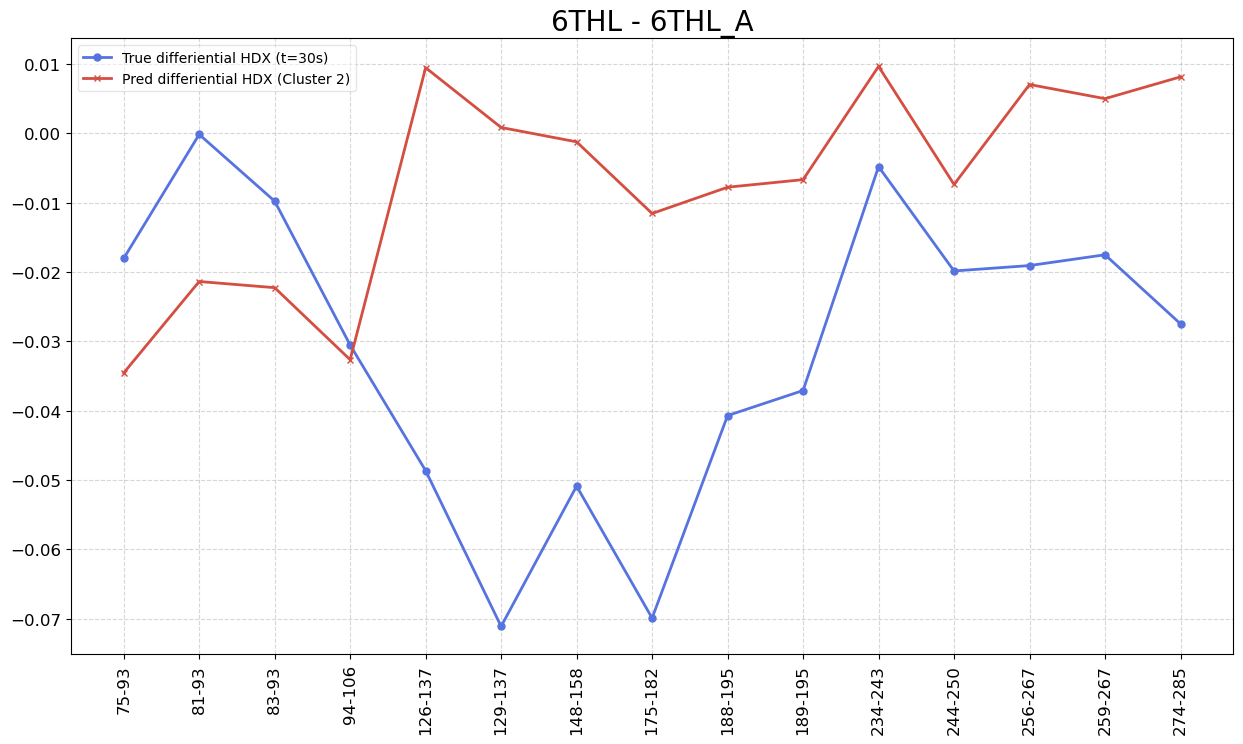

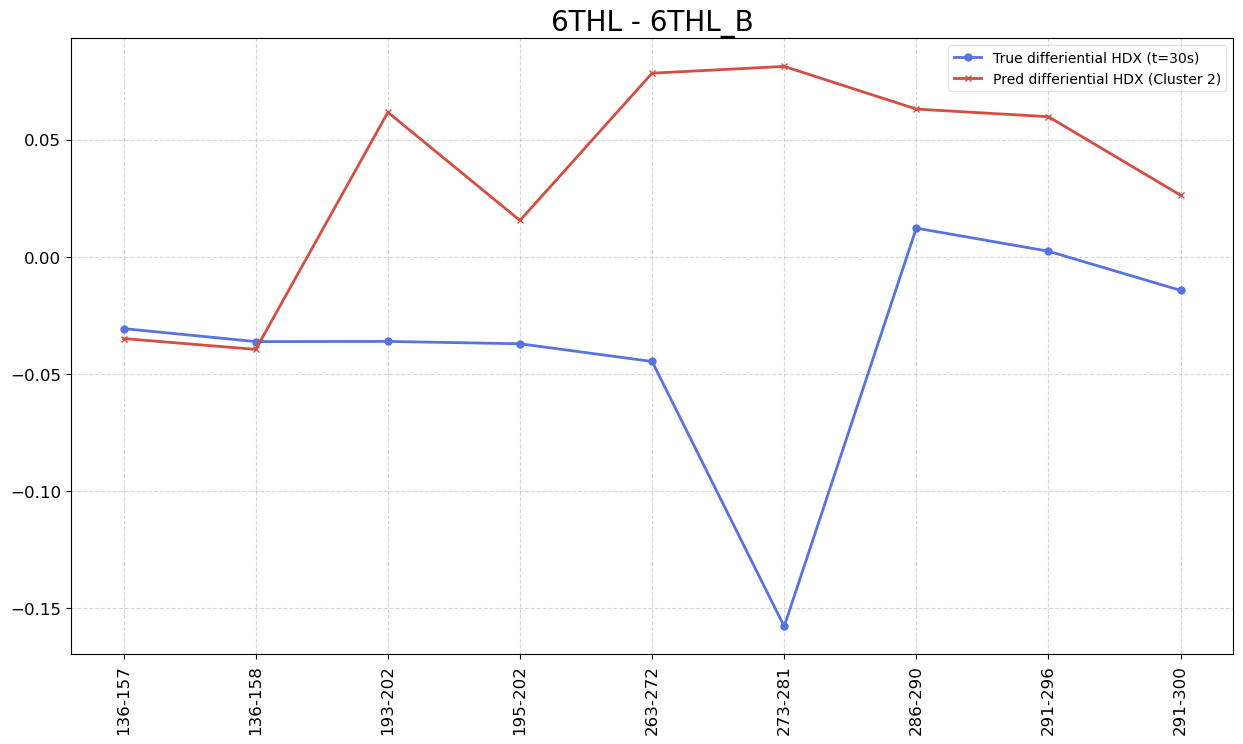

In [29]:
# show HDX difference
import seaborn as sns
palette = sns.color_palette("coolwarm", 10)

def HDX_error(y_true, y_pred, error_limit):
    epsilon = 1e-12
    weight = ((y_true+epsilon)/0.1) ** 2
    return np.mean((weight * (((y_true - y_pred)/error_limit) ** 2)))

def get_diff_HDX(HDX_fpath, apo_states, complex_states, df, batch_apo, batch_complex):
    true_diff, diff_RFU_mtx = get_true_diff(HDX_fpath, apo_states, complex_states)
    complex_pred_df = df[(df['Batch'] == batch_complex)]
    apo_pred_df = df[(df['Batch'] == batch_apo)]
    print(complex_pred_df.shape, apo_pred_df.shape)

    pred_diff = {}
    for key in true_diff.keys():
        if key in complex_pred_df['Range'].values and key in apo_pred_df['Range'].values:
            complex_value = complex_pred_df[complex_pred_df['Range'] == key]['Y_Pred'].values[0]
            apo_value = apo_pred_df[apo_pred_df['Range'] == key]['Y_Pred'].values[0]
            pred_diff[key] = complex_value - apo_value
    all_times = set()
    for diffs in diff_RFU_mtx.values():
        all_times.update(diffs.keys())
    sorted_times = sorted(all_times, key=lambda x: float(x))

    trim_true_diff = {key: true_diff[key] for key in pred_diff.keys()}
    print('data utilization rate:', len(trim_true_diff.keys())/len(true_diff.keys()))

    x_labels = list(pred_diff.keys())
    x_index = np.arange(len(x_labels))
    y_true = np.array([trim_true_diff[key] for key in x_labels])
    y_pred = np.array([pred_diff[key] for key in x_labels])

    loss = HDX_error(y_true, y_pred, 1)
    print('loss:', loss, 'length:', len(y_true))

    #plt.figure(figsize=(30, 6))
    plt.figure(figsize=(15, 8))
    plt.title(f'{batch_complex} - {batch_apo}', fontsize=20)
    plt.xticks(x_index, x_labels, rotation=90)
    plt.tick_params(axis='both', labelsize=12)
    for time in sorted_times:
        time_values = [diff_RFU_mtx[label].get(time, 0) / 100 for label in x_labels]
        #plt.plot(x_index, time_values, label=f'time_{time}', linestyle='--', alpha=1)
    plt.plot(x_labels, y_true, label='True differiential HDX (t=30s)', color=palette[0], marker='o', linestyle='-', linewidth=2, markersize=5)
    plt.plot(x_labels, y_pred, label='Pred differiential HDX (Cluster 2)', color=palette[-1], marker='x', linestyle='-', linewidth=2, markersize=5)
    #plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(True, linestyle='--', alpha = 0.5)
    plt.legend(fancybox = True, framealpha =0.5)
    #plt.show()
    plt.savefig(f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/diff_HDX_{batch_apo}_cluster{cluster_id}.png', dpi=300)


apo_states = [('rtt', 'Rtt', 0)]
complex_states = [('rtt', 'Rtt_Bcd', 0)]
get_diff_HDX(HDX_fpath, apo_states, complex_states, average_df, batch_apo='6THL_A', batch_complex='6THL')

apo_states = [('bcdFL', 'Bcd', 0)]
complex_states = [('bcdFL', 'Bcd_Rtt', 0)]
get_diff_HDX(HDX_fpath, apo_states, complex_states, average_df, batch_apo='6THL_B', batch_complex='6THL')
#get_diff_HDX(HDX_fpath, apo_states, complex_states, average_df, batch_apo='6THL_B', batch_complex='MODEL_476_REVISED')
#plt.savefig(f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/diff_HDX_6DJL-C_cluster{cluster_id}.png', dpi=300)

In [8]:
## extract binding site

from collections import defaultdict
import os
import numpy as np
from scipy.spatial.distance import cdist
from Bio import PDB
from itertools import groupby

class Chain:
    def __init__(self):
        self.atoms = []
        self.sequence_type = None

    def add_atom(self, atom_index, residue_index, residue_type, atom_type, coordinates):
        atom_info = {
            'atom_index': atom_index,
            'residue_index': residue_index,
            'residue_type': residue_type,
            'atom_type': atom_type,
            'coordinates': coordinates
        }
        self.atoms.append(atom_info)

    def get_atoms(self):
        return self.atoms
    
    def get_residues(self):
        # group atoms by residue
        atoms = self.get_atoms()
        key = lambda x: x['residue_index']
        #atoms = sorted(atoms, key=key)
        residues = [list(group) for key, group in groupby(atoms, key)]
        return residues

def read_PDB(key, PDB_path):
    if not os.path.isfile(PDB_path):
        print("cannot find the file", key)
        return None
    chains = defaultdict(Chain)

    with open(PDB_path, 'r') as f:
        data = f.read().strip().split('\n') 
        for line in data:
            if line[:4] == 'ATOM':
                n_res = int(line[23:26].strip())
                n_atom = int(line[6:11].strip())
                res_type = line[17:20].strip()
                atom_type = line[12:16].strip()
                chain = line[21].strip()
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                chain_id = line[21].strip()
                if atom_type == 'CA':
                    chains[chain_id].add_atom(n_atom, n_res, res_type, atom_type, [x, y, z])
    return chains

def bindingsite_extract(chains, chain1 = 'A', chain2 = 'B', dist_cutoff=3.65): ###assume only two chains in the PDB file
    chainA = chains[chain1]
    chainB = chains[chain2]
    coords_a = [atom['coordinates'] for atom in chainA.get_atoms()]
    coords_b = [atom['coordinates'] for atom in chainB.get_atoms()]

    coords_array_a = np.array(coords_a)
    coords_array_b = np.array(coords_b)
    dist_matrix = cdist(coords_array_a, coords_array_b, 'euclidean')

    pairs = dist_criterion(dist_matrix, cutoff=dist_cutoff) # different criterion can be used here
    contact_list = []
    for pair in pairs:
        resA_id = pair[0]
        resB_id = pair[1]

        resA = chainA.get_atoms()[resA_id]['residue_index']
        resB = chainB.get_atoms()[resB_id]['residue_index']
        contact_list.append((resA, resB))
    contact_list = np.array(contact_list)
    if contact_list.shape[0] == 0:
        return None, None
    
    max_res_A = max([res['residue_index'] for res in chainA.get_atoms()])
    max_res_B = max([res['residue_index'] for res in chainB.get_atoms()])
    contact_resmap = np.zeros((max_res_A, max_res_B))
    contact_resmap[contact_list[:, 0]-1, contact_list[:, 1]-1] = 1

    return contact_resmap, contact_list

def dist_criterion(dist_matrix, cutoff):
    dist_matrix = np.array(dist_matrix)
    mask = dist_matrix < cutoff
    indices = np.where(mask)
    pairs = list(zip(indices[0], indices[1]))
    return pairs

In [9]:
# calculate structure RMSD
from Bio.PDB import PDBParser
import numpy as np
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
from tqdm import tqdm
from DockQ.DockQ import load_PDB, run_on_all_native_interfaces

def get_backbone_atoms(structure, ref_chains=['A']):
    atoms = []
    for model in structure:
        for chain in model:
            if chain.id in ref_chains:
                continue
            for residue in chain:
                # Check if the residue has the backbone atoms (N, CA, C)
                try:
                    #atoms.append(residue['N'].get_coord())
                    atoms.append(residue['CA'].get_coord())
                    #atoms.append(residue['C'].get_coord())
                except KeyError:
                    # Skip residues that don't have a complete set of backbone atoms
                    continue
    return atoms

def get_RMSD(pdb_dir, model2, ref_model, ref_chains=['A']): # ref_chains: chains to be excluded/ not compared
    parser = PDBParser()
    structure1 = parser.get_structure("Protein1", f"{pdb_dir}/{ref_model}.pdb")
    structure2 = parser.get_structure("Protein2", f"{pdb_dir}/{model2}.pdb")

    backbone_atoms1 = get_backbone_atoms(structure1, ref_chains)
    backbone_atoms2 = get_backbone_atoms(structure2, ref_chains)
    # calcualte the distance between backbone_atoms1 and backbone_atoms2
    rmsd = np.sqrt(np.sum((np.array(backbone_atoms1) - np.array(backbone_atoms2))**2)/len(backbone_atoms1))
    return rmsd

def preload_pdb_structures(pdb_dir, model_list):
    parser = PDBParser()
    structures = {}
    for model in tqdm(model_list):
        path = f"{pdb_dir}/{model}.pdb"
        try:
            structure = parser.get_structure(model, path)
            structures[model] = structure
        except Exception as e:
            print(f"Failed to parse {model}: {e}")
    return structures

def get_dockQ_score(pdb_dir, test_model, native_model, chain_map = {"A": "A", "B": "B"}):
    model = load_PDB(f"{pdb_dir}/{test_model}.pdb")
    native = load_PDB(f"{pdb_dir}/{native_model}.pdb")

    dockQ = run_on_all_native_interfaces(model, native, chain_map=chain_map)
    return dockQ

rtt Rtt (22, 11)
rtt Rtt_Bcd (22, 11)
22
bcdFL Bcd (49, 11)
bcdFL Bcd_Rtt (49, 11)
49


500it [00:53,  9.39it/s]


[(0.0, 423, 63.67992881068047, 0.5394905716260243), (0.018636223702243167, 217, 57.50381146787866, 0.48815282851219277), (0.08095477754304437, 457, 67.8189624416849, 0.545611610228058), (0.08237522350009761, 194, 45.69426477506048, 0.47605884095172285), (0.10073031177181384, 237, 79.22546413033291, 0.4944219567578242), (0.1522798026608127, 134, 38.571966018081056, 0.4494027051041565), (0.16697660906866002, 368, 80.73577016003088, 0.5298153815776484), (0.1791928235534895, 314, 83.63847300535004, 0.5165366768683977), (0.1826923885445559, 341, 81.96430879758987, 0.5245335176226676), (0.19872848448265373, 475, 70.1725611142513, 0.5478823180965544)]
[1, 277, 4, 227, 313, 130, 484, 439, 413, 90, 482, 126, 93, 468, 371, 163, 349, 107, 40, 398, 425, 73, 411, 499, 176, 491, 329, 410, 212, 67, 406, 495, 365, 429, 472, 415, 246, 263, 433, 185, 278, 409, 275, 494, 427, 221, 284, 356, 267, 147]
[423, 217, 457, 194, 237, 134, 368, 314, 341, 475, 218, 495, 497, 500, 201, 127, 98, 433, 384, 55, 469, 4

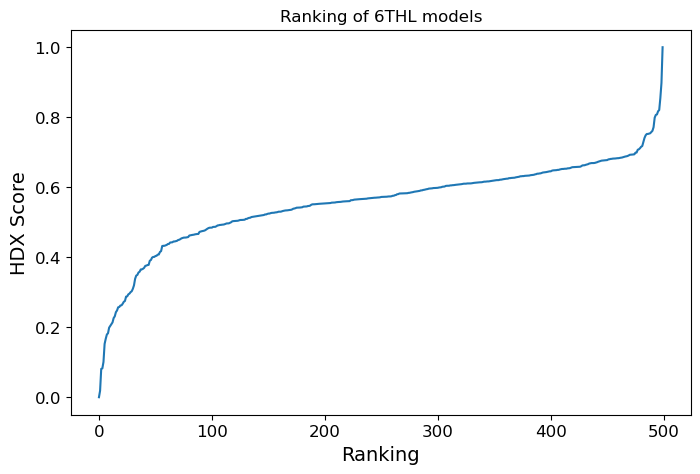

In [30]:
# batch MAE
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)  # Clip predictions to avoid log(0)
    bce = -np.sum(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred)) / y_true.shape[0]
    return bce
def mean_squared_error(y_true, y_pred, error_limit, d=0.05):
    epsilon = 1e-12
    weight = ((y_true)/d+epsilon) ** 2 # difference above 0.1 will give higher weight
    return np.mean((weight * (((y_true - y_pred)/error_limit) ** 2)))

def Inverse_Square_Scale(y, d):
    return 1- 1/(1+(y/d)**2)

def max_min_scale(y):
    y = np.array(y)
    return (y - np.min(y)) / (np.max(y) - np.min(y))

def get_chi_score(df, complex_batchname, apo_batchname, true_diff):
    complex_pred_df = df[(df['Batch'] == complex_batchname)]
    apo_pred_df = df[df['Batch'] == apo_batchname]
    if complex_pred_df.shape[0] == 0 or apo_pred_df.shape[0] == 0:
        return None

    pred_diff = {}
    for key in true_diff.keys():
        if key in complex_pred_df['Range'].values and key in apo_pred_df['Range'].values:
            complex_value = complex_pred_df[complex_pred_df['Range'] == key]['Y_Pred'].values[0]
            apo_value = apo_pred_df[apo_pred_df['Range'] == key]['Y_Pred'].values[0]
            pred_diff[key] = complex_value - apo_value

    trim_true_diff = {key: true_diff[key] for key in pred_diff.keys()}

    x_labels = list(pred_diff.keys())
    y_true = np.array([trim_true_diff[key] for key in x_labels])
    y_pred = np.array([pred_diff[key] for key in x_labels])

    if y_true.shape[0] == 0 or y_pred.shape[0] == 0:
        return None

    error_limit = 1
    #loss = Inverse_Square_Scale(mean_squared_error(y_true, y_pred, error_limit), 0.01)
    loss = mean_squared_error(y_true, y_pred, error_limit, d=0.05)
    return loss

apo_states = [('rtt', 'Rtt', 0)]
complex_states = [('rtt', 'Rtt_Bcd', 0)]
true_diff_ligand, _ = get_true_diff(HDX_fpath, apo_states, complex_states)

apo_states = [('bcdFL', 'Bcd', 0)]
complex_states = [('bcdFL', 'Bcd_Rtt', 0)]
true_diff_target, _ = get_true_diff(HDX_fpath, apo_states, complex_states)

pdb_dir = f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/structure/{protein_name}'
ref_model = '6THL'
ref_chains = ['A']
complex_batches = [f'MODEL_{i}_REVISED' for i in range(1, 501)]
#structures = preload_pdb_structures(pdb_dir, complex_batches)
#chain_map = {"A": "A", "C": "C"}

apo_ref = ['6THL_A', '6THL_B']
maes = []
rmsd = []

for i, batch in tqdm(enumerate(complex_batches)):
    mae_ligand = get_chi_score(average_df, batch, apo_ref[0], true_diff_ligand)
    #mae_ligand = None
    mae_target = get_chi_score(average_df, batch, apo_ref[1], true_diff_target)
    if mae_target is not None and mae_ligand is not None:
        mae = (mae_ligand + mae_target) / 2
        #mae = mae_target
        maes.append(mae)
        rmsd.append(get_RMSD(pdb_dir, batch, ref_model, ref_chains))
        #dockQ = get_dockQ_score(pdb_dir, batch, ref_model, chain_map=chain_map)
        #rmsd.append(dockQ[1])

score_fpath = '/home/lwang/models/HDOCKlite-v1.1/6THL.out'
ITscore = []
with open(score_fpath, 'r') as f:
    lines = f.readlines()[5:]
    for line in lines:
        values = line.strip().split()
        ITscore.append(float(values[6]))
ITscore = max_min_scale(ITscore)

maes = max_min_scale(maes)
batch_id = [int(i.split('_')[1]) for i in complex_batches]
sorted_batch = sorted(zip(maes, batch_id , rmsd, ITscore), key=lambda x: x[0], reverse=False)
print(sorted_batch[:10])

HDX_top30 = [id for _, id, _, _ in sorted_batch[:50]]

rmsd_sorted = sorted(zip(rmsd, batch_id, maes, ITscore), key=lambda x: x[0], reverse=False)
rmsd_top30 = [id for _, id, _,_ in rmsd_sorted[:50]]
print(rmsd_top30)
print(HDX_top30)

plt.figure(figsize = (8, 5))
plt.plot([i[0] for i in sorted_batch])
plt.ylabel('HDX Score', fontsize=14)
plt.xlabel('Ranking', fontsize=14)
plt.title(f'Ranking of {ref_model} models')
plt.tick_params(axis='both', labelsize=12)

#plt.show()
plt.savefig(f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/hdock_files/{ref_model}_ranking.png')

In [17]:
print(rmsd_sorted)

[(67.37794600528791, 282, 0.3940711757417498, 0.4401682627763358), (67.69169701400794, 237, 0.17632445381545878, 0.42235746889823683), (67.83121005815202, 393, 0.25531136452853925, 0.4748948357647902), (67.95161521159277, 291, 0.30616787791957667, 0.44231629821892066), (67.9826399469406, 126, 0.9170907087161599, 0.36767206658909884), (68.00090211195332, 63, 0.24583623372399555, 0.29920343685670825), (68.26315178404808, 107, 0.16787649325291695, 0.35308332587487684), (68.32593516035017, 37, 0.11718899835443168, 0.25194665711984254), (68.35370311814137, 118, 0.33251318232566895, 0.3646290163787704), (68.42255110256761, 306, 0.14591964516410072, 0.4488499060234495), (68.59288346574665, 144, 0.25301365792616326, 0.3776067305110534), (68.63053570799202, 34, 0.11033431871835149, 0.24066947104627218), (68.63125885293519, 337, 0.7869741252679151, 0.4595005817595991), (68.63656767133394, 354, 0.20821903590320778, 0.46325964378412254), (68.65004672190582, 138, 0.5155894062739335, 0.3737581670097

Top 5 hit: 0/5
Top 10 hit: 0/10
Top 25 hit: 0/25
Top 50 hit: 5/50


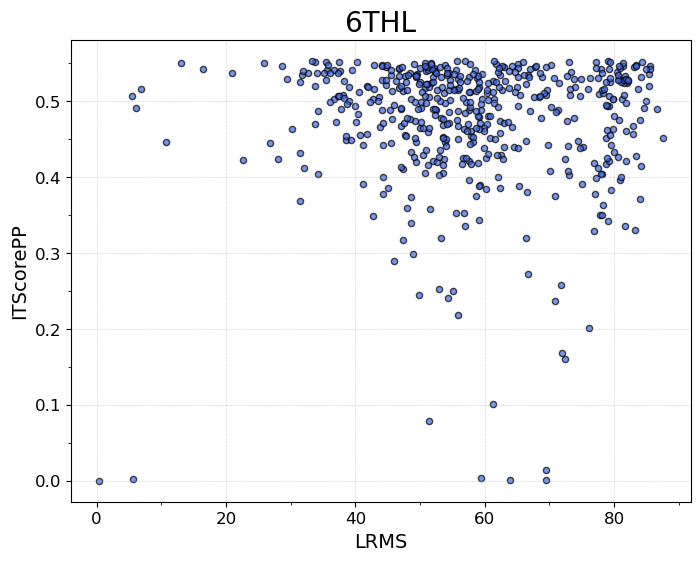

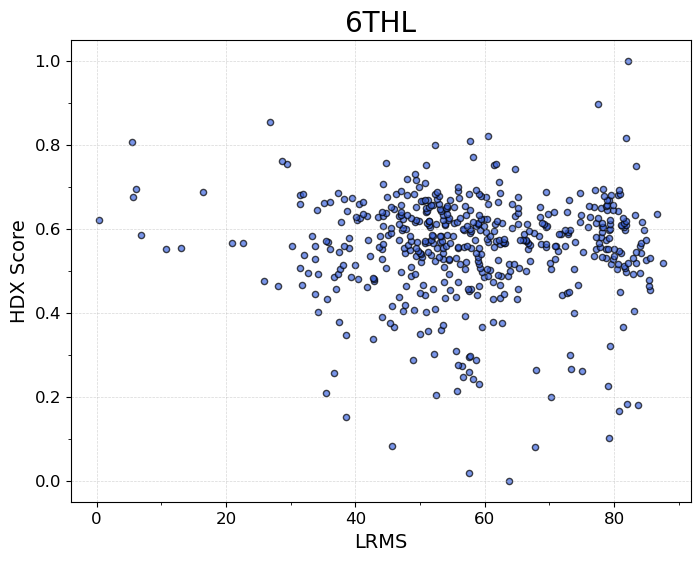

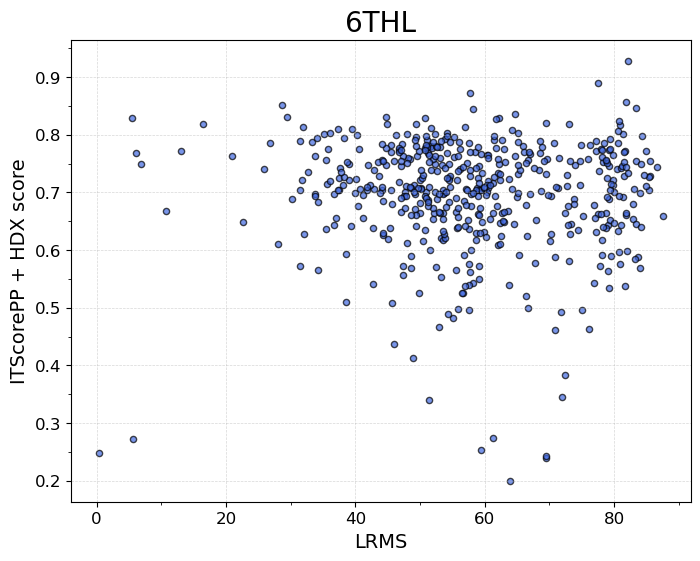

In [31]:
# plot RMSD and mae index
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from matplotlib.ticker import AutoMinorLocator

top5_common = len(set(HDX_top30[:5]).intersection(set(rmsd_top30[:5])))
top10_common = len(set(HDX_top30[:10]).intersection(set(rmsd_top30[:10])))
top25_common = len(set(HDX_top30[:25]).intersection(set(rmsd_top30[:25])))
top50_common = len(set(HDX_top30[:50]).intersection(set(rmsd_top30[:50])))

print(f"Top 5 hit: {top5_common}/5")
print(f"Top 10 hit: {top10_common}/10")
print(f"Top 25 hit: {top25_common}/25")
print(f"Top 50 hit: {top50_common}/50")


maes = [i[0] for i in sorted_batch]
rmsd = [i[2] for i in sorted_batch]
ITscore = [i[3] for i in sorted_batch]

plt.figure(figsize=(8, 6))
plt.ylabel('ITScorePP', fontsize=14)
plt.xlabel('LRMS', fontsize=14)
plt.grid(True, which = 'major', linestyle='--', linewidth=0.5, alpha = 0.5)
#plt.scatter(rmsd[:10], maes[:10], alpha=0.7, edgecolor='black', color='yellow', s=20, label = 'top10 decoys')
plt.scatter(rmsd, ITscore, alpha=0.7, edgecolor='black', color='royalblue', s=20)
plt.title(f'{protein_name}', fontsize=20)
plt.minorticks_on()
plt.tick_params(axis='both', labelsize=12)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
#plt.legend()
#plt.show()
plt.savefig(f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/{protein_name}_RMSD_ITScore.png', dpi = 300)

plt.figure(figsize=(8, 6))
plt.ylabel('HDX Score', fontsize=14)
plt.xlabel('LRMS', fontsize=14)
plt.grid(True, which = 'major', linestyle='--', linewidth=0.5, alpha = 0.5)
#plt.scatter(rmsd[:10], maes[:10], alpha=0.7, edgecolor='black', color='yellow', s=20, label = 'top10 decoys')
plt.scatter(rmsd, maes, alpha=0.7, edgecolor='black', color='royalblue', s=20)
plt.title(f'{protein_name}', fontsize=20)
plt.minorticks_on()
plt.tick_params(axis='both', labelsize=12)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
#plt.legend()
#plt.show()
plt.savefig(f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/{protein_name}_RMSD_MAE.png', dpi = 300)

combine_score = [j + 0.4*i for i, j in zip(maes, ITscore)]
plt.figure(figsize=(8, 6))
plt.title(f'{protein_name}', fontsize=20)
plt.ylabel('ITScorePP + HDX score', fontsize=14)
plt.xlabel('LRMS', fontsize=14)
plt.grid(True, which = 'major', linestyle='--', linewidth=0.5, alpha = 0.5)
plt.scatter(rmsd, combine_score, alpha=0.7, edgecolor='black', color='royalblue', s=20)
plt.minorticks_on()
plt.tick_params(axis='both', labelsize=12)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.savefig(f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/{protein_name}_RMSD_combineScore.png', dpi = 300)
#plt.show()


In [14]:
id_list = [80, 84, 50, 69, 1, 12, 40, 96, 67, 41]
pdb_list = [f'{protein_name}_{i}_revised.pdb' for i in id_list]

rec_chain = ['A', 'C']
lig_chain = ['D', 'E']

map_dict = {}
for pdb in pdb_list:
    print(pdb)
    pdb_fpath = f'/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/hdock/{protein_name}/{pdb}'
    chains = read_PDB('model1', pdb_fpath)
    for rec in rec_chain:
        for lig in lig_chain:
            contact_, contact_list = bindingsite_extract(chains, chain1=rec, chain2=lig, dist_cutoff=10)
            if contact_list is None:
                continue
            if (rec, lig) not in map_dict.keys():
                map_dict[(rec, lig)] = []
            map_dict[(rec, lig)].extend(list(contact_list))
print(map_dict.keys())

D_contact = map_dict[('A', 'D')] + map_dict[('C', 'D')]
E_contact = map_dict[('A', 'E')] + map_dict[('C', 'E')]

D_res_map = np.zeros((999, 128))
E_res_map = np.zeros((999, 105))

for pos in D_contact:
    D_res_map[pos[0]-1, pos[1]-1] += 1
for pos in E_contact:
    E_res_map[pos[0]-1, pos[1]-1] += 1

Hdock_Wuhan+V16ext_80_revised.pdb
Hdock_Wuhan+V16ext_84_revised.pdb
Hdock_Wuhan+V16ext_50_revised.pdb
Hdock_Wuhan+V16ext_69_revised.pdb
Hdock_Wuhan+V16ext_1_revised.pdb
Hdock_Wuhan+V16ext_12_revised.pdb
Hdock_Wuhan+V16ext_40_revised.pdb
Hdock_Wuhan+V16ext_96_revised.pdb
Hdock_Wuhan+V16ext_67_revised.pdb
Hdock_Wuhan+V16ext_41_revised.pdb
dict_keys([('A', 'D'), ('A', 'E'), ('C', 'E'), ('C', 'D')])


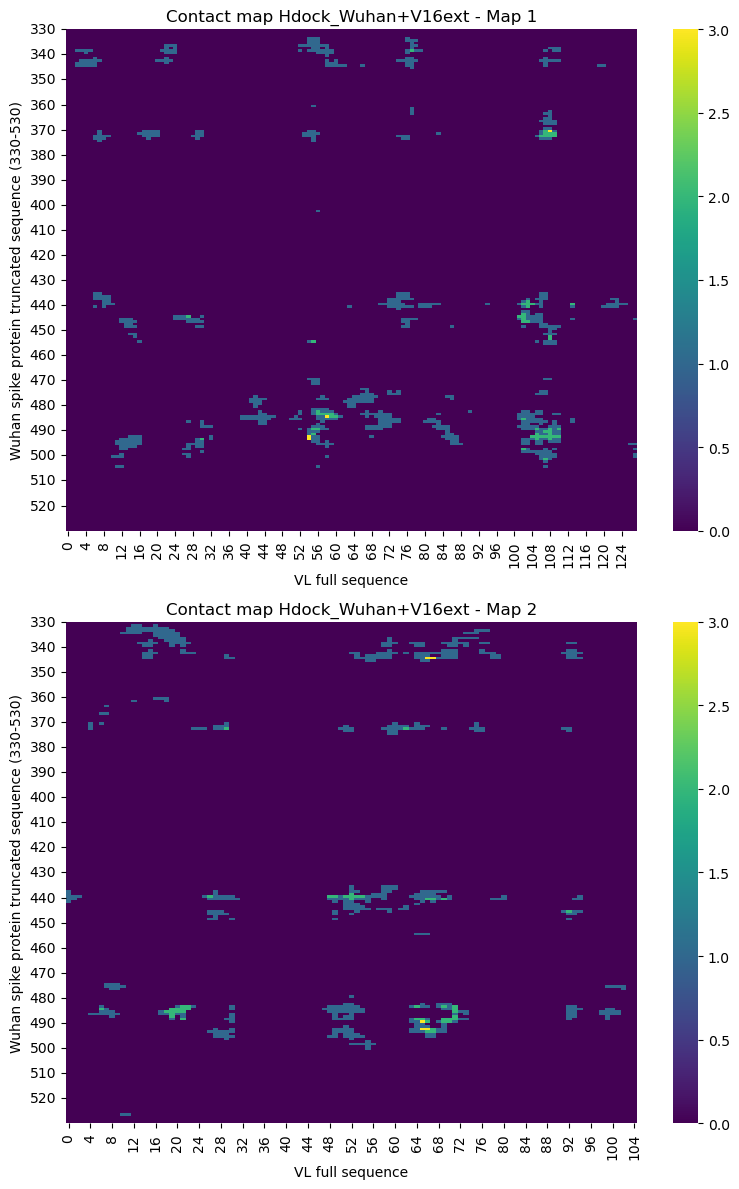

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns
def plot_resmap(res_map1, res_map2):
    fig, axs = plt.subplots(2, 1, figsize=(8,12))  # create a figure with two subplots arranged vertically

    # plot the first heatmap
    sns.heatmap(res_map1, cmap='viridis', ax=axs[0])
    axs[0].set_xlabel('VL full sequence')
    axs[0].set_ylabel('Wuhan spike protein truncated sequence (330-530)')
    axs[0].set_title(f'Contact map {protein_name} - Map 1')
    axs[0].set_yticks(np.arange(0, res_map1.shape[0], 10))
    axs[0].set_yticklabels(np.arange(330, 530, 10))

    # plot the second heatmap
    sns.heatmap(res_map2, cmap='viridis', ax=axs[1])
    axs[1].set_xlabel('VL full sequence')
    axs[1].set_ylabel('Wuhan spike protein truncated sequence (330-530)')
    axs[1].set_title(f'Contact map {protein_name} - Map 2')
    axs[1].set_yticks(np.arange(0, res_map2.shape[0], 10))
    axs[1].set_yticklabels(np.arange(330, 530, 10))

    plt.tight_layout()  # adjust the layout so that the plots do not overlap
    plt.savefig(f'/home/lwang/models/HDX_LSTM/results/240411_BiLSTMGAT_v2_1/{protein_name}_resmap.png')

plot_resmap(D_res_map[330:530, :], E_res_map[330:530, :])

In [1]:
from pyhdx import read_dynamx, HDXMeasurement
from pyhdx.process import filter_peptides, apply_control, correct_d_uptake
from pyhdx.plot import peptide_coverage
import proplot as pplt
from pathlib import Path
import pandas as pd
import numpy as np

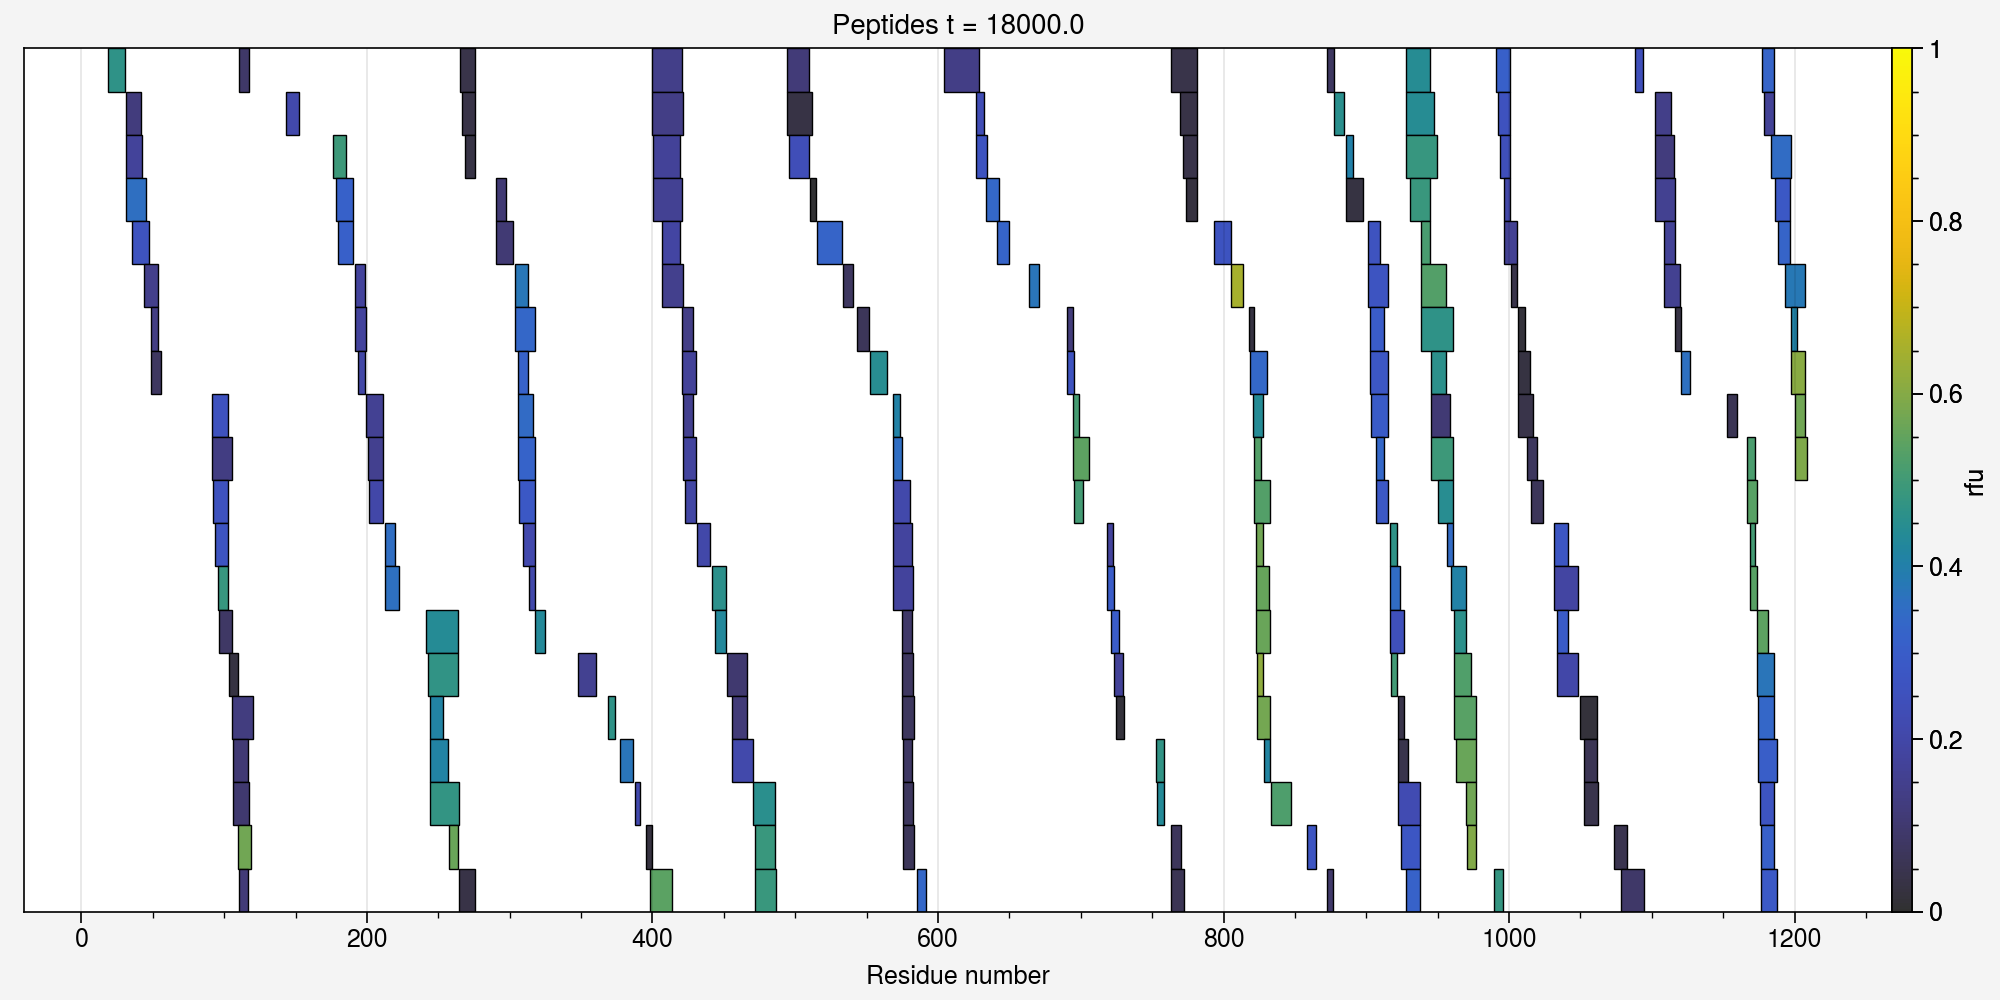

In [4]:
fpath = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/HDX_files/COVID_SPIKE.csv'
data = read_dynamx(fpath)
data['rfu'] = data['%d'] / 100

peptides = data[(data['protein'] == 'WUHAN_2nd') & (data['state'] == 'apo')]

peptides_corrected = correct_d_uptake(peptides, drop_first=1, d_percentage=90.0)

sequence = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"
temperature, pH = 273.15 + 25, 7.5

hdxm = HDXMeasurement(
    peptides_corrected, sequence = sequence, pH=pH, temperature=temperature, name="My HDX measurement"
)

fig, ax = pplt.subplots(figsize=(10, 5))
i = 0
peptide_coverage(ax, hdxm[i].data, 20, cbar=True)
t = ax.set_title(f"Peptides t = {hdxm.timepoints[i]}")
l = ax.set_xlabel("Residue number")

In [5]:
import numpy as np
import pandas as pd
import proplot as pplt
from scipy.optimize import lsq_linear
from pathlib import Path
import yaml

from pyhdx.models import Coverage
from pyhdx.plot import peptide_coverage
from pyhdx.batch_processing import StateParser
from pyhdx.fitting import fit_d_uptake
from pyhdx.config import cfg

/home/lwang/models/mambaforge/envs/pyhdx/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
def compute_d_uptake(fpath, states, sequence):
    data = read_dynamx(fpath)
    data['rfu'] = data['%d'] / 100

    fit_result = []
    for state in states:
        peptides = data[(data['protein'] == state[0]) & (data['state'] == state[1])]
        peptides_corrected = correct_d_uptake(peptides, drop_first=1, d_percentage=90.0)
        temperature, pH = 273.15 + 25, 7.5
        hdxm = HDXMeasurement(
            peptides_corrected, sequence = sequence, pH=pH, temperature=temperature, name="My HDX measurement"
        )
        hdx_t = hdxm[1]
        fit_result.append(fit_d_uptake(hdx_t, r1=1.0, repeats=20))
    
    fit_diff = fit_result[1].d_uptake.mean(axis=0) - fit_result[0].d_uptake.mean(axis=0)

    return hdx_t.r_number ,fit_diff

sequence = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"
fpath = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/HDX_files/COVID_SPIKE.csv'
states = [('WUHAN_2nd', 'apo', 'A'), ('WUHAN_2nd', 'VH16_VL104', 'A')]
r_id, fit_diff = compute_d_uptake(fpath, states, sequence)


100%|██████████| 20/20 [04:00<00:00, 12.03s/it]


In [6]:
hdx_t = hdxm[1]
b = hdx_t.data["uptake_corrected"].values
X_inv = np.linalg.pinv(hdx_t.X)
d_inv = X_inv.dot(b)
# Remove parts which do not exchange (prolines, coverage gaps)
d_inv[~hdx_t["exchanges"]] = np.nan

res = lsq_linear(hdx_t.X, b, method="bvls", bounds=(0, 1))
d_lsq = res.x
d_lsq[~hdx_t["exchanges"]] = np.nan

fit_result_1 = fit_d_uptake(hdx_t, r1=1.0, repeats=20)

100%|██████████| 20/20 [04:03<00:00, 12.18s/it]


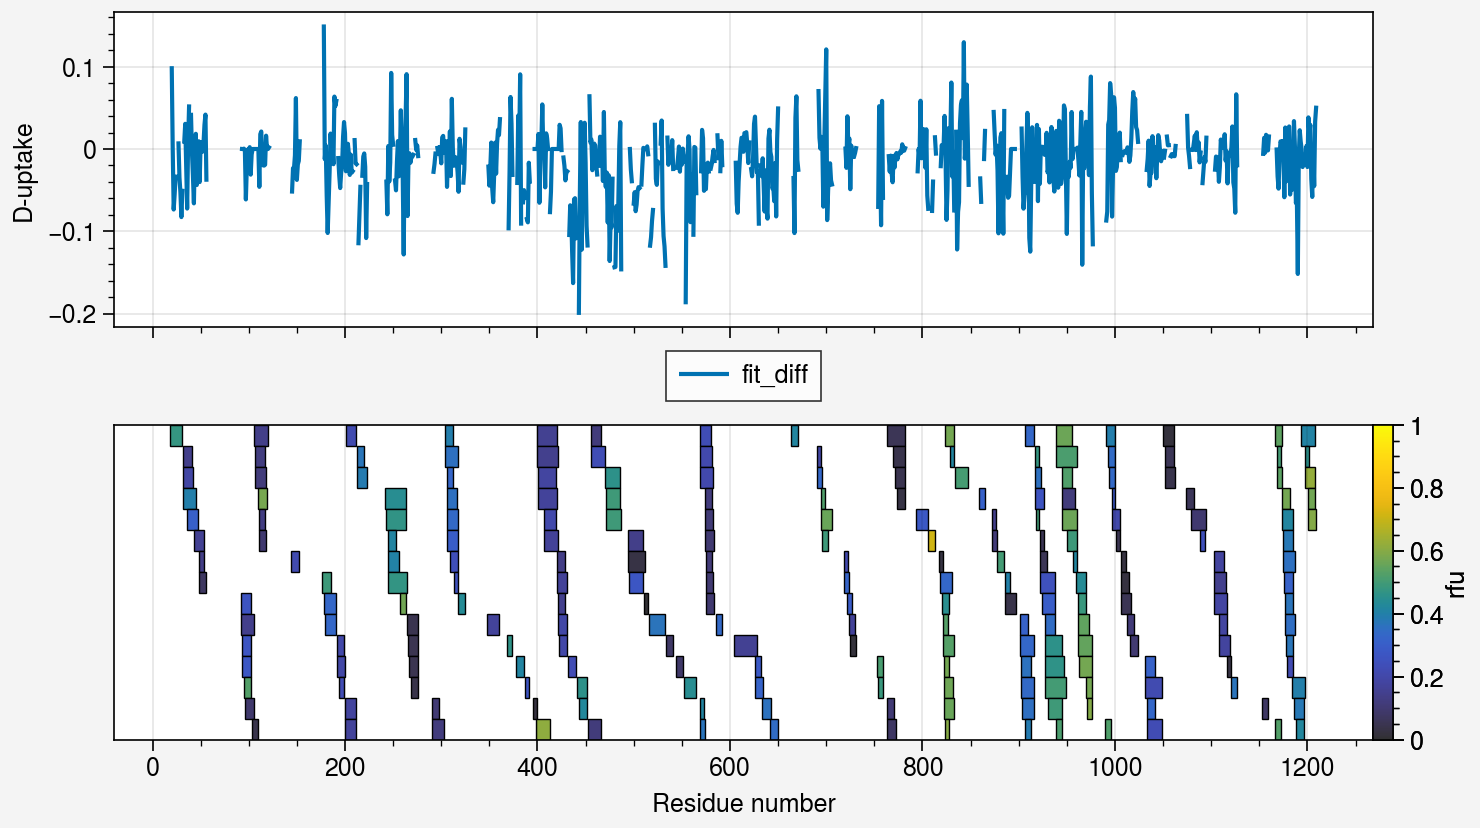

In [33]:
d_rfu = hdx_t.rfu_residues * 90.0 * 0.01

def prepare_kwargs(fit_result):
    """Prepare plot kwargs for fit result"""
    d = {
        "y": fit_result.d_uptake.mean(axis=0),
        "fadedata": np.percentile(fit_result.d_uptake, (5, 95), axis=0),
        "shadedata": np.percentile(fit_result.d_uptake, (25, 75), axis=0),
    }
    return d

fig, axes = pplt.subplots(nrows=2, refaspect=4, axwidth="160mm", sharey=False)
#axes[0].plot(hdx_t.r_number, d_inv, label="Matrix pinv", color="gray8")
#axes[0].plot(hdx_t.r_number, d_lsq, label="LSQ", color="gray5")

#axes[0].line(hdx_t.r_number, **prepare_kwargs(fit_result_1), label="fit_r1_1")
#axes[0].line(hdx_t.r_number, **prepare_kwargs(fit_result_02), label="fit_r1_02")
axes[0].line(hdx_t.r_number, fit_diff, label="fit_diff")

#axes[0].plot(hdx_t.r_number, d_rfu, label="RFU wt averaging")
axes[0].format(ylabel="D-uptake")
axes.format(xlabel="Residue number")
axes[0].legend(loc="b", ncols=5)
peptide_coverage(axes[1], hdx_t.data)
pplt.show()

In [31]:
# replace the b-factor by residue wise D-uptake
from Bio.PDB import PDBParser, PDBIO

# Define the path to your PDB file
pdb_file = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/structure/Wuhan_spike_bfac_to_Duptake.pdb'

# Create a PDB parser
parser = PDBParser()

# Parse the structure from file
structure = parser.get_structure('PDB', pdb_file)

# Define the chain you want to modify and the new B-factors
chain_id = 'B'  # Specify the chain ID
new_b_factors = d_uptake_dict # Dictionary of residue index to new B-factor values

# Update the B-factors for the specified chain
for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                for atom in residue:
                    atom.bfactor = 0.0
                if residue.id[1] in new_b_factors:  # residue.id[1] gives the residue index
                    for atom in residue:
                        atom.bfactor = new_b_factors[residue.id[1]]

# Save the modified structure to a new PDB file
io = PDBIO()
io.set_structure(structure)
io.save('/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/structure/Wuhan_spike_bfac_to_Duptake.pdb')